<h1><center>Sistemas Distribuídos – 2023/1

Prof. Rodolfo da Silva Villaça – rodolfo.villaca@ufes.br \\
Monitor: Eduardo M. Moraes Sarmento – eduardo.sarmento@ufes.br

Laboratório II – Aprendizado Federado usando a biblioteca Flower</h1></center>

<u>Objetivo</u>:\
Experimentar o treinamento de modelos de aprendizado de máquina por meio do *framework* de aprendizado *flwr*, disponível na biblioteca *flower* Comparar os resultados atingidos pelo modelo treinado de maneira local e federada.

Este roteiro de laboratório foi testado usando o [Google Colab](https://colab.research.google.com/), ambiente de desenvolvimento colaborativo Python disponibilizado pelo Google como um serviço em nuvem.\
\
Para a execução do código deste roteiro são necessárias as bibliotecas *tensorflow* (versão 2.12.0), *numpy* (versão 1.22.4), *ray* (versão 2.2.0), *matplotlib* (versão 3.7.1) e *flower* (versão 1.3.0). As quatro primeiras já vem instaladas no **Google Colab**,. ntão, caso esteja executando por ele, não é necessária sua instalação. A biblioteca flower não vem instalada,  então precisamos instalá-la, e também o seu módulo de simulação, para podermos simular o treinamento federado no *notebook*.

A célula seguinte executa a instalação de todas as bibliotecas necessárias. Caso esteja fora do Colab, é preciso descomentar as linhas de 3 a 5.

In [1]:
#%pip install flwr==1.3.0
#%pip install -U flwr["simulation"]
#%pip install ray==2.2.0
#%pip install tensorflow==2.12.0
#%pip install numpy==1.22.4
#%pip install matplotlib==3.7.1
!poetry install

Installing dependencies from lock file

No dependencies to install or update


###Célula de Importação 

Importamos a biblioteca *os*, que lida com o sistema operacional. Utilizamos ela para configurar a *flag* "TF_CPP_MIN_LOG_LEVEL" com o valor 3, isto faz com que os logs do *tensorflow* sejam menos verbosos durante o treinamento.\
Depois, importamos as demais bibliotecas: 

1.   *flower*, para efetuar o aprendizado federado;
2.   *tensorflow*, para definir uma arquitetura de rede neural, incluindo todas as camadas e otimizador que usaremos;
3.   *numpy*, biblioteca de maniupulação eficiente de vetores numéricos;
4.   *ray*, biblioteca utilizada pelo *flower* para instanciar a simulação do aprendizado federado.
5.   *matplotlib*, biblioteca para plotar gráficos.





In [2]:
import os
# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import flwr as fl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import ray
from matplotlib import pyplot as plt

#### Importação e Pré-rocessamento dos Dados

Neste laboratório usaremos o *dataset* MNIST, muito usado como referência na literatura. Este *dataset* é composto por imagens monocromáticas de 28 por 28 píxels (*28x28*), representando dígitos de 0 a 9 escritos a mão e anotadas com o valor do dígito. Ele contém dois *subdatasets*: o de treino e o de teste. O *subdataset* de treino é formado por 60 mil imagens, enquanto o *subdataset* de treino contém 10 mil imagens.

O *tensorflow* já nos provê esse *dataset*, separando os *subdatasets* de treino entre: atributos alvo, tambem chamados de classes ou *targets* (*y_train e y_test*), e atributos não alvo (*x_train* e *x_test*), ou *features*. Sendo assim, para carregar este *dataset* basta instanciar (atribuição da variavel *mnist*) e carregar (método *load_data*).

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 4s 0us/step


Plotamos, como exemplo, os 10 primeiros dígitos do *dataset* de treino com suas classes. Por meio desse *plot* conseguiremos visualizar bem o tipo de dado que o *dataset* descreve.

 Vemos que as classes são o valor numérico que o digito representa e as imagens são dígitos escritos a mão, em preto e branco.

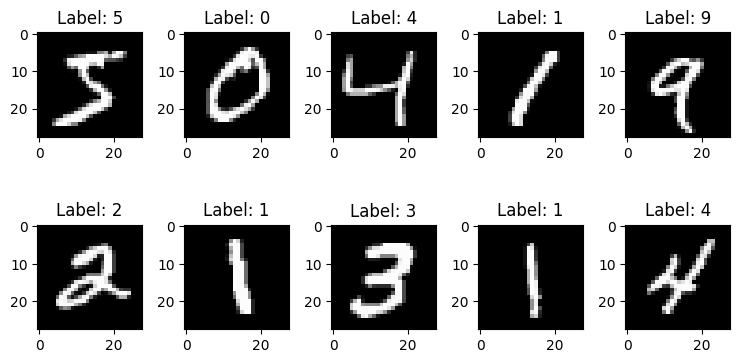

In [4]:
num = 10
images = x_train[:num]
labels = y_train[:num]
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

**Pré-Processamento dos Dados**

 Primeiro trabalhamos com os dados dos atributos não alvo (*features*), checando o formato dos *datasets* nas variáveis *x_train e x_test*. emos que eles têm os formatos (60000, 28, 28) e (10000, 28, 28) respectivamente.

 O primeiro número indica a quantidade de imagens contidas em cada *dataset*: 60000 para o treino e 10000 para o teste. Os outros dois números são a quantidade de pixeis de cada imagem, 28 píxeis verticais e 28 píxeis horizontais.

Sendo assim, cada imagem é representada como matrizes de números (28 x 28). Já que as imagens são monocromáticas, cada elemento da matriz significa a luminosidade doassociad àquela posição do *pixel*,em valores que vão de 0 a 255.

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Para usar os *datasets* no treinamento e teste de modelos de aprendizado de máquina é necessario, inicialmente, pré-processar os dados.

Primeiro fazemos o *reshape*, incluindo uma nova dimensão que indica que as imagens são monocromaticas (*reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)*). 

Depois normalizamos os dados dos atributos não alvo, dividindo os valores de luminosidade dos pixeis pelo maior valor possivel, *255*, com isso fazendo com que estes valores fiquem na faixa entre 0 e 1. 

Com essas duas ações encerramos  pré-processamento dos atributos não alvo (*features*).

In [6]:
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

Para os atributos alvo (*target*) é necessário fazer o *one hot enconding* das classes. Esta operação consistem em transformar as classes adicionando novas colunas, que indicam a presença ou não da classe. Isto é, como neste *dataset* as classes são os números de 0 a 9, adicionamos 9 novas colunas, numeradas de 0 a 9. Para cada amostra, cada uma destas novas colunas terá os valores 0 ou 1, onde 0 indica   que a amostra não é daquela classe e 1 indica que a amostra é daquela classe. 

Printamos a primeira amostra do conjunto de treinamento , antes e depois da aplicação da operação, para vermos seu efeito sobre a amostra.

In [7]:
print(y_train[0])
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
print(y_train[0])

5
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


#### Treinamento Local

A técnica de aprendizado federado foi desenvolvida inicialmente para o treinamento de redes neurais, por isso precisamos definir uma rede neural para podermos usá-la localmente e,  futuramente, comparar os  resultados do  modelos gerados localmente e federado.

Esta próxima célula define uma função que monta uma rede neural convolucional simples, que usaremos na etapa de treinamento. A rede neural recebe como atributos: o formato dos dados de entrada (*input_shape*) e o numero de classes do problema (*num_classes*).

In [8]:
def define_model(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(num_classes, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Conforme explicado anteriormente,  após o pré-processamento,  cada imagem do *dataset* terá o seguinte formato: 28 pixeis verticais, 28 pixeis horizontais e 1 canal de cor. Desta forma o formato de entrada dos dados é (28, 28, 1). 

Temos digitos de 0 a 9 em nosso *dataset*, ou seja, 10 possiveis classes. Com isso instanciamos uma rede neural usando a função *define_model* na variavel model.

In [9]:
input_shape = (28, 28, 1)
num_classes = 10

model = define_model(input_shape,num_classes)

Inicialmente treinaremos a rede neural localmente para termos um *baseline* de comparação. A rede neural  é treinada por 5 épocas, usando 10% do *dataset* de treino para validação durante o treinamento. 

Usamos 64 como *batch_size*, isso significa que  expomos a rede neural a 64 amostras (lote, ou *batch*) antes de atualizarmos o valor da função de perda. Esse processo  é repetido até que todas as amostras tenham sido expostas à rede neural, terminando uma época de treinamento. 

In [10]:
batch_size = 64
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.2215 - accuracy: 0.9324 - val_loss: 0.0944 - val_accuracy: 0.9755
Epoch 2/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0843 - accuracy: 0.9748 - val_loss: 0.0635 - val_accuracy: 0.9838
Epoch 3/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0556 - accuracy: 0.9840 - val_loss: 0.0548 - val_accuracy: 0.9858
Epoch 4/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0404 - accuracy: 0.9883 - val_loss: 0.0489 - val_accuracy: 0.9873
Epoch 5/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0304 - accuracy: 0.9910 - val_loss: 0.0523 - val_accuracy: 0.9872


Como conclusão, com o conjunto de teste usado neste laboratório, e usando  o nosso modelo,  obtivemos uma acurácia de ~98,39%, que é um resultado aceitável com relação a este *dataset*, comparando-se com os resultados de referência encontrados na literatura. Ver [referência](https://paperswithcode.com/sota/image-classification-on-mnist).

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 477us/step - loss: 0.0435 - accuracy: 0.9859


#### Treinamento Federado

Agora começaremos o treinamento federado desta mesma rede neural usando a biblioteca *flower*. Esta biblioteca implementa a arquitetura de aprendizado federado, onde no treinamento temos dois agentes: o servidor e os clientes. 
 
* Os clientes (treinadores) têm como tarefa treinar seus modelos usando seus dados locais e, após o treinamento, enviar os pesos encontrados para o servidor de agregação. Quando receberem os pesos agregados pelo servidor, os clientes atualizam seus modelos locais com estes pesos e recomeçam o treinamento, assim iniciando uma nova rodada (época).
* O servidor de agregação, por sua vez, recebe estes pesos e usa algum algoritmo para agregar os diferentes pesos dos modelos gerados pelos clientes treinadores. Em seguida o servidor deve enviar de volta os pesos agregados para os clientes. 

Ao final desse processo,  os  pesos agregados representam o modelo global que está sendo treinado por esse conjunto de treinadores.







Sabendo disso, para o uso da biblioteca *flower* temos, como primeiro passo, que implementar o código dos clientes. Para isso definimos uma classe cliente que herda da super classe *NumPyClient* provida pela biblioteca *numpy*. Para seu uso temos que implementar obrigatoriamente 3 métodos em nosso cliente:


1.  *get_parameters(self, config)*: este método recebe um dicionário de configuração e é chamado pelo servidor como um procedimento remoto. Ele retorna os pesos do modelo do cliente na rodada atual.
2.  *fit(self, parameters, config)*: por este método, chamado via RPC pelo servidor, o cliente recebe os pesos do modelo global e um dicionário de configuração. Ele realiza o treinamento do modelo, primeiro setando os pesos do modelo com os recebidos pelo cliente do servidor e depois treinando um novo modelo com esses novos pesos iniciais. Ela retorna: os pesos encontrados após essa rodada de treinamento, o tamanho do conjunto de treinamento e um dicionário de métricas de avaliação do modelo. O dicionário pode ser retornado vazio.
3.  *evaluate(self, parameters, config)*: por este método, chamado remotamente pelo servidor, o cliente recebe os pesos do modelo global e um dicionário de configuração. Ele avalia localmente o modelo treinado e retorna o valor da função de perda encontrado para este cliente, o tamanho do conjunto de teste e um dicionário de métricas de avaliação do modelo. Neste caso, retornaremos a acurácia.

Também definimos um método opcional *\_\_init\_\_(self, model, x_train, y_train, x_test, y_test)* que é o de inicialização do objeto, recebendo o modelo pré-instanciado e os conjuntos de teste e treino.



In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test) -> None:
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

Como estamos usando um *notebook*, não podemos instanciar clientes e servidores do *flower* diretamente. Por isso a biblioteca prove uma alternativa que é o módulo de simulação. Ele simula o aprendizado federado sem o uso de conexões de rede.\
\
Para o seu uso temos que definir uma função que instancias os clientes com a assinatura *fn(str) -> fl.client.Client*. Esta função recebe uma *string* que é um identificador único do cliente usado pela simulação e nos retorna o cliente instanciado. Internamente ela particiona o *dataset*, amostrando, sem reposição, um número aleatório de imagens, compondo um conjunto de dados que representa os dados locais daquele cliente. 

A seguir faremos os mesmos passos anteriores de pré-processamento e instanciamento da rede neural. Finalmente instanciaremos um cliente *flower* e retornamos.

In [13]:
def client_fn_random(cid: str) -> fl.client.Client:
    input_shape = (28, 28, 1)
    num_classes = 10
    num_clients = 10
    partition_size = 500
    

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    #sample_size_train = int(cid) * partition_size
    #sample_size_test = int(cid) * partition_size
    sample_size_train = int((1/num_clients)*len(x_train))
    sample_size_test = int((1/num_clients)*len(x_test))
    idx_train = np.random.choice(np.arange(len(x_train)), sample_size_train, replace=False)
    x_train = x_train[idx_train]/255.0
    y_train = y_train[idx_train]
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    idx_test = np.random.choice(np.arange(len(x_test)), sample_size_test, replace=False)
    x_test = x_test[idx_test]/255.0
    y_test = y_test[idx_test]
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    model = define_model(input_shape,num_classes)
    # Create and return client
    return FlowerClient(model, x_train, y_train, x_test, y_test)

Para a avaliação do modelo precisamos de uma função de agregação de métricas. Isto é necessário pois, a priori, a simulação não sabe que tipo de métrica será usada para avaliar o modelo. Por isso o programador tem que criar uma função que lide com a agregação dos valores de métricas que ele esta usando para avaliar seu modelo. Desta maneira esta função é usada para que a simulação consiga retornar a evolução dos valores das métricas em cada *round* usando um objeto do tipo *history*.


Aqui definimos a função de agregação como a média ponderada da acurácia pelo tamanho do conjunto de dados de cada cliente.

In [14]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    acc = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    results = {"accuracy": sum(acc) / sum(examples)}
    return results

Precisamos agora definir o número de clientes que participação do aprendizado federado, 10 clientes neste exemplo, e uma estratégia de agregação dos pesos a ser usada pelo servidor.

Esta estratégia é um objeto do tipo *strategy* da biblioteca *flower*. Além de definir o algoritmo de agregação dos pesos, no caso usamos o *Federated Average (FedAvg)*, também é preciso configurar o comportamento do servidor durante o processo de treinamento. Com essa biblioteca nós configuramos o servidor para:

1.   Escolher aleatoriamente 90% dos clientes (9 clientes neste exemplo) para o treinamento (*fraction_fit*);
2.   Usar todos os clientes para a avaliação do modelo (*fraction_evaluate*);
3.   Nunca usar menos que 9 clientes para o treinamento (*min_fit_clients*);
4.   Nunca usar menos que 9 clientes para a avaliação do modelo (*min_evaluate_clients*);
5.   Esperar que tenha pelo menos 9 clientes prontos antes de começar o treinamento(*min_available_clients*);
6.   Usar a função *weighted_average*, definida anteriormente, como função de agregação de métricas

Finalmente iniciamos a simulação usando a função *fl.simulation.start_simulation*. Passamos para essa função a função de instanciamento de clientes (*client_fn_random*), o número de clientes (*num_clients*), um dicionário de configuração, que diz para o servidor quantos *rounds* de treinamento queremos (*fl.server.ServerConfig(num_rounds=5)*) e a estratégia de treinamento (*strategy*). 


In [15]:
num_clients = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.9,  
    fraction_evaluate=1,  
    min_fit_clients=9,  
    min_evaluate_clients=9,  
    min_available_clients=int(
        num_clients * 0.9
    ),  
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flwr 2023-04-18 20:59:22,204 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-18 20:59:23,785	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-18 20:59:24,303 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 7898834534.0, 'memory': 15797669070.0, 'CPU': 12.0, 'node:192.168.0.240': 1.0}
INFO flwr 2023-04-18 20:59:24,303 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-18 20:59:24,303 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-18 20:59:25,220 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-18 20:59:25,220 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-18 20:59:25,220 | server.py:101 | FL starting
DEBUG flwr 2023-04-18 20:59:25,220 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=30607) 188/188 - 1s - loss: 0.5189 - accuracy: 0.8342 - 683ms/epoch - 4ms/step
(launch_and_fit pid=30606) 188/188 - 2s - loss: 0.5035 - accuracy: 0.8373 - 2s/epoch - 9ms/step
(launch_and_fit pid=30598) 188/188 - 2s - loss: 0.5095 - accuracy: 0.8343 - 2s/epoch - 9ms/step


DEBUG flwr 2023-04-18 20:59:28,855 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-18 20:59:28,871 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-18 20:59:28,872 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=30603) 188/188 - 2s - loss: 0.4923 - accuracy: 0.8410 - 2s/epoch - 10ms/step
(launch_and_fit pid=30597) 188/188 - 2s - loss: 0.4874 - accuracy: 0.8488 - 2s/epoch - 10ms/step
(launch_and_fit pid=30608) 188/188 - 2s - loss: 0.4825 - accuracy: 0.8488 - 2s/epoch - 10ms/step
(launch_and_fit pid=30604) 188/188 - 2s - loss: 0.5232 - accuracy: 0.8383 - 2s/epoch - 11ms/step
(launch_and_fit pid=30599) 188/188 - 2s - loss: 0.4909 - accuracy: 0.8490 - 2s/epoch - 11ms/step
(launch_and_fit pid=30602) 188/188 - 2s - loss: 0.4912 - accuracy: 0.8470 - 2s/epoch - 10ms/step
(launch_and_evaluate pid=30607) 32/32 - 0s - loss: 0.2412 - accuracy: 0.9280 - 191ms/epoch - 6ms/step
(launch_and_evaluate pid=30599) 32/32 - 0s - loss: 0.2306 - accuracy: 0.9380 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=30604) 32/32 - 0s - loss: 0.2457 - accuracy: 0.9350 - 218ms/epoch - 7ms/step
(launch_and_evaluate pid=30603) 32/32 - 0s - loss: 0.2403 - accuracy: 0.9290 - 241ms/epoch - 8ms/step
(launch_an

DEBUG flwr 2023-04-18 20:59:30,195 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-18 20:59:30,195 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=30600) 32/32 - 0s - loss: 0.2648 - accuracy: 0.9280 - 123ms/epoch - 4ms/step
(launch_and_fit pid=30604) 188/188 - 2s - loss: 0.2403 - accuracy: 0.9315 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-18 20:59:32,897 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-18 20:59:32,905 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=30599) 188/188 - 2s - loss: 0.2415 - accuracy: 0.9270 - 2s/epoch - 12ms/step
(launch_and_fit pid=30602) 188/188 - 2s - loss: 0.2543 - accuracy: 0.9247 - 2s/epoch - 13ms/step
(launch_and_fit pid=30598) 188/188 - 2s - loss: 0.2245 - accuracy: 0.9295 - 2s/epoch - 13ms/step
(launch_and_fit pid=30600) 188/188 - 2s - loss: 0.2416 - accuracy: 0.9280 - 2s/epoch - 13ms/step
(launch_and_fit pid=30603) 188/188 - 2s - loss: 0.2532 - accuracy: 0.9227 - 2s/epoch - 13ms/step
(launch_and_fit pid=30597) 188/188 - 2s - loss: 0.2456 - accuracy: 0.9250 - 2s/epoch - 13ms/step
(launch_and_fit pid=30606) 188/188 - 2s - loss: 0.2171 - accuracy: 0.9318 - 2s/epoch - 13ms/step
(launch_and_fit pid=30608) 188/188 - 2s - loss: 0.2290 - accuracy: 0.9275 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-18 20:59:33,389 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-18 20:59:33,389 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=30597) 32/32 - 0s - loss: 0.1352 - accuracy: 0.9550 - 115ms/epoch - 4ms/step
(launch_and_evaluate pid=30607) 32/32 - 0s - loss: 0.1444 - accuracy: 0.9560 - 196ms/epoch - 6ms/step
(launch_and_evaluate pid=30599) 32/32 - 0s - loss: 0.1315 - accuracy: 0.9540 - 194ms/epoch - 6ms/step
(launch_and_evaluate pid=30606) 32/32 - 0s - loss: 0.1477 - accuracy: 0.9590 - 185ms/epoch - 6ms/step
(launch_and_evaluate pid=30604) 32/32 - 0s - loss: 0.1460 - accuracy: 0.9630 - 224ms/epoch - 7ms/step
(launch_and_evaluate pid=30603) 32/32 - 0s - loss: 0.1198 - accuracy: 0.9590 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=30602) 32/32 - 0s - loss: 0.1345 - accuracy: 0.9570 - 225ms/epoch - 7ms/step
(launch_and_evaluate pid=30608) 32/32 - 0s - loss: 0.1647 - accuracy: 0.9430 - 237ms/epoch - 7ms/step
(launch_and_evaluate pid=30598) 32/32 - 0s - loss: 0.1634 - accuracy: 0.9500 - 226ms/epoch - 7ms/step
(launch_and_evaluate pid=30600) 32/32 - 0s - loss: 0.1733 - accuracy: 0.9470 - 223

DEBUG flwr 2023-04-18 20:59:36,095 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-18 20:59:36,104 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=30607) 188/188 - 2s - loss: 0.1603 - accuracy: 0.9530 - 2s/epoch - 13ms/step
(launch_and_fit pid=30604) 188/188 - 2s - loss: 0.1750 - accuracy: 0.9470 - 2s/epoch - 13ms/step
(launch_and_fit pid=30599) 188/188 - 2s - loss: 0.1758 - accuracy: 0.9432 - 2s/epoch - 13ms/step
(launch_and_fit pid=30606) 188/188 - 2s - loss: 0.1722 - accuracy: 0.9473 - 2s/epoch - 13ms/step
(launch_and_fit pid=30608) 188/188 - 2s - loss: 0.1657 - accuracy: 0.9500 - 2s/epoch - 13ms/step
(launch_and_fit pid=30600) 188/188 - 2s - loss: 0.1609 - accuracy: 0.9497 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-18 20:59:36,575 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-18 20:59:36,575 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=30599) 32/32 - 0s - loss: 0.1213 - accuracy: 0.9610 - 135ms/epoch - 4ms/step
(launch_and_evaluate pid=30607) 32/32 - 0s - loss: 0.1122 - accuracy: 0.9670 - 163ms/epoch - 5ms/step
(launch_and_evaluate pid=30604) 32/32 - 0s - loss: 0.1124 - accuracy: 0.9670 - 224ms/epoch - 7ms/step
(launch_and_evaluate pid=30603) 32/32 - 0s - loss: 0.0805 - accuracy: 0.9760 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=30597) 32/32 - 0s - loss: 0.1099 - accuracy: 0.9720 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=30602) 32/32 - 0s - loss: 0.1147 - accuracy: 0.9660 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=30606) 32/32 - 0s - loss: 0.1307 - accuracy: 0.9550 - 230ms/epoch - 7ms/step
(launch_and_evaluate pid=30608) 32/32 - 0s - loss: 0.1105 - accuracy: 0.9660 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=30598) 32/32 - 0s - loss: 0.1356 - accuracy: 0.9520 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=30600) 32/32 - 0s - loss: 0.1143 - accuracy: 0.9620 - 246

DEBUG flwr 2023-04-18 20:59:39,213 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-18 20:59:39,220 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=30597) 188/188 - 2s - loss: 0.1335 - accuracy: 0.9607 - 2s/epoch - 11ms/step
(launch_and_fit pid=30603) 188/188 - 2s - loss: 0.1359 - accuracy: 0.9585 - 2s/epoch - 12ms/step
(launch_and_fit pid=30598) 188/188 - 2s - loss: 0.1306 - accuracy: 0.9620 - 2s/epoch - 12ms/step
(launch_and_fit pid=30600) 188/188 - 2s - loss: 0.1376 - accuracy: 0.9568 - 2s/epoch - 12ms/step
(launch_and_fit pid=30607) 188/188 - 2s - loss: 0.1402 - accuracy: 0.9540 - 2s/epoch - 13ms/step
(launch_and_fit pid=30604) 188/188 - 2s - loss: 0.1298 - accuracy: 0.9600 - 2s/epoch - 13ms/step
(launch_and_fit pid=30602) 188/188 - 2s - loss: 0.1420 - accuracy: 0.9593 - 2s/epoch - 13ms/step
(launch_and_fit pid=30606) 188/188 - 2s - loss: 0.1225 - accuracy: 0.9617 - 2s/epoch - 13ms/step
(launch_and_fit pid=30608) 188/188 - 2s - loss: 0.1156 - accuracy: 0.9640 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-18 20:59:39,693 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-18 20:59:39,693 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=30607) 32/32 - 0s - loss: 0.0951 - accuracy: 0.9690 - 239ms/epoch - 7ms/step
(launch_and_evaluate pid=30604) 32/32 - 0s - loss: 0.0873 - accuracy: 0.9750 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=30603) 32/32 - 0s - loss: 0.1039 - accuracy: 0.9680 - 226ms/epoch - 7ms/step
(launch_and_evaluate pid=30597) 32/32 - 0s - loss: 0.0871 - accuracy: 0.9740 - 234ms/epoch - 7ms/step
(launch_and_evaluate pid=30599) 32/32 - 0s - loss: 0.0765 - accuracy: 0.9790 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=30602) 32/32 - 0s - loss: 0.0754 - accuracy: 0.9780 - 232ms/epoch - 7ms/step
(launch_and_evaluate pid=30606) 32/32 - 0s - loss: 0.1100 - accuracy: 0.9660 - 234ms/epoch - 7ms/step
(launch_and_evaluate pid=30608) 32/32 - 0s - loss: 0.0681 - accuracy: 0.9770 - 225ms/epoch - 7ms/step
(launch_and_evaluate pid=30598) 32/32 - 0s - loss: 0.0933 - accuracy: 0.9720 - 235ms/epoch - 7ms/step
(launch_and_evaluate pid=30600) 32/32 - 0s - loss: 0.1062 - accuracy: 0.9670 - 208

DEBUG flwr 2023-04-18 20:59:42,319 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-18 20:59:42,328 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=30602) 188/188 - 2s - loss: 0.1122 - accuracy: 0.9653 - 2s/epoch - 12ms/step
(launch_and_fit pid=30603) 188/188 - 2s - loss: 0.1096 - accuracy: 0.9690 - 2s/epoch - 12ms/step
(launch_and_fit pid=30608) 188/188 - 2s - loss: 0.1017 - accuracy: 0.9708 - 2s/epoch - 12ms/step
(launch_and_fit pid=30607) 188/188 - 2s - loss: 0.1035 - accuracy: 0.9678 - 2s/epoch - 13ms/step
(launch_and_fit pid=30604) 188/188 - 2s - loss: 0.1201 - accuracy: 0.9620 - 2s/epoch - 12ms/step
(launch_and_fit pid=30597) 188/188 - 2s - loss: 0.1188 - accuracy: 0.9663 - 2s/epoch - 13ms/step
(launch_and_fit pid=30606) 188/188 - 2s - loss: 0.1140 - accuracy: 0.9673 - 2s/epoch - 13ms/step
(launch_and_fit pid=30598) 188/188 - 2s - loss: 0.1145 - accuracy: 0.9638 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-18 20:59:42,790 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-04-18 20:59:42,790 | server.py:144 | FL finished in 17.570198406000145
INFO flwr 2023-04-18 20:59:42,791 | app.py:202 | app_fit: losses_distributed [(1, 0.24461216181516648), (2, 0.14607231244444846), (3, 0.11421726271510124), (4, 0.09030177518725395), (5, 0.08460740633308887)]
INFO flwr 2023-04-18 20:59:42,791 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9306999981403351), (2, 0.9542999982833862), (3, 0.9644000113010407), (4, 0.9724999964237213), (5, 0.9736999988555908)]}
INFO flwr 2023-04-18 20:59:42,791 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-18 20:59:42,792 | app.py:205 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=30604) 32/32 - 0s - loss: 0.0951 - accuracy: 0.9690 - 136ms/epoch - 4ms/step
(launch_and_evaluate pid=30597) 32/32 - 0s - loss: 0.0743 - accuracy: 0.9810 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=30599) 32/32 - 0s - loss: 0.1001 - accuracy: 0.9650 - 159ms/epoch - 5ms/step
(launch_and_evaluate pid=30602) 32/32 - 0s - loss: 0.0996 - accuracy: 0.9710 - 201ms/epoch - 6ms/step
(launch_and_evaluate pid=30598) 32/32 - 0s - loss: 0.0792 - accuracy: 0.9750 - 213ms/epoch - 7ms/step


(launch_and_evaluate pid=30607) 32/32 - 0s - loss: 0.0546 - accuracy: 0.9800 - 231ms/epoch - 7ms/step
(launch_and_evaluate pid=30603) 32/32 - 0s - loss: 0.0766 - accuracy: 0.9730 - 213ms/epoch - 7ms/step
(launch_and_evaluate pid=30606) 32/32 - 0s - loss: 0.0938 - accuracy: 0.9760 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=30608) 32/32 - 0s - loss: 0.0680 - accuracy: 0.9830 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=30600) 32/32 - 0s - loss: 0.1049 - accuracy: 0.9640 - 216ms/epoch - 7ms/step


Printamos os resultados do treinamento retornados no formato do objeto *history*. Ele tem dois atributos: um dicionário com a média da função de perda a cada *round* e um dicionário com os valores das métricas agregadas a cada *round*, calculadas pela função de agregação. 

Podemos observar a evolução destes dois valores a cada *round*. Para os 4 primeiros *rounds* tivemos uma melhora do valor da função de perda e da acurácia, mas no último *round* a função de perda diminuiu pouco e a acurácia se manteve estável.

O número de *rounds* de treinamento é um valor muito importante para o aprendizado federado. Similar ao número de épocas de treinamento no aprendizado local, precisamos de *rounds* suficientes para que o modelo convirja com pesos adequados, mas temos que tomar cuidado para não causar o *overfitting* da rede, caso tenhamos muitos *rounds*.

In [16]:
print(history)

History (loss, distributed):
	round 1: 0.24461216181516648
	round 2: 0.14607231244444846
	round 3: 0.11421726271510124
	round 4: 0.09030177518725395
	round 5: 0.08460740633308887
History (metrics, distributed):
{'accuracy': [(1, 0.9306999981403351), (2, 0.9542999982833862), (3, 0.9644000113010407), (4, 0.9724999964237213), (5, 0.9736999988555908)]}


A seguir plotaremos a acurácia por *round*. Observe que ela parece estar tendendo a aumentar a cada *round* e, **talvez**, se aumentássemos o numero de *rounds* teríamos uma acurácia ainda melhor.

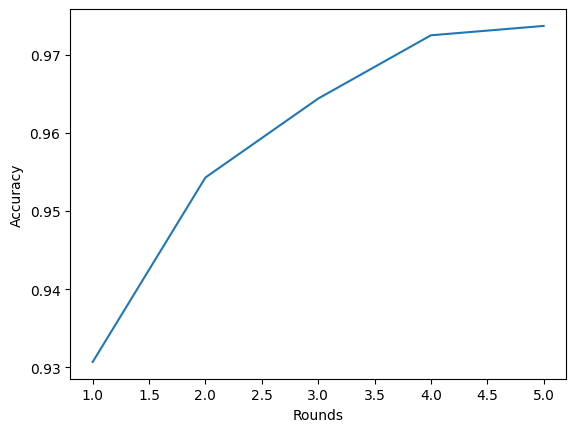

In [17]:
plt.plot(*zip(*history.metrics_distributed['accuracy']))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

#### Atividades

**Atividade 1** 

Durante a configuração do treinamento federado definimos valores para muitos hyper-parâmetros. Um dos mais importantes é foi o número de *rounds*. Por isso nesta tarefa vocês deverão treinar a rede de maneira federada variando o número de rounds em diferentes valores. 

 

*   Os valores a serem usados para o número de *rounds* são 10, 15, 20;
*   Para cada valor deve-se plotar um gráfico de linha que relaciona o número de *rounds* com a acurácia obtida naquele número de *rounds*.

Além   disso deve-se comparar a desempenho do modelo federado com os diferentes valores de *rounds* e o  desempenho encontrado quando treinamos localmente a rede neural.





INFO flwr 2023-04-18 21:11:09,982 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-04-18 21:11:13,369	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-18 21:11:13,876 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.0.240': 1.0, 'object_store_memory': 7783843430.0, 'memory': 15567686862.0, 'CPU': 12.0}
INFO flwr 2023-04-18 21:11:13,876 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-18 21:11:13,877 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-18 21:11:14,835 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-18 21:11:14,835 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-18 21:11:14,835 | server.py:101 | FL starting
DEBUG flwr 2023-04-18 21:11:14,835 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=50867) 188/188 - 1s - loss: 0.5299 - accuracy: 0.8300 - 882ms/epoch - 5ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.4954 - accuracy: 0.8417 - 2s/epoch - 10ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.5273 - accuracy: 0.8327 - 2s/epoch - 10ms/step


DEBUG flwr 2023-04-18 21:11:18,559 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-18 21:11:18,571 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-18 21:11:18,572 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.5372 - accuracy: 0.8350 - 2s/epoch - 10ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.5093 - accuracy: 0.8447 - 2s/epoch - 11ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.5606 - accuracy: 0.8237 - 2s/epoch - 11ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.5025 - accuracy: 0.8425 - 2s/epoch - 11ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.5579 - accuracy: 0.8230 - 2s/epoch - 11ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.5175 - accuracy: 0.8355 - 2s/epoch - 11ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.3340 - accuracy: 0.9020 - 229ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.3509 - accuracy: 0.8840 - 213ms/epoch - 7ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.3209 - accuracy: 0.9080 - 234ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.3639 - accuracy: 0.8770 - 241ms/epoch - 8ms/step
(launch_an

DEBUG flwr 2023-04-18 21:11:19,918 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:19,919 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.3885 - accuracy: 0.8840 - 129ms/epoch - 4ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.2671 - accuracy: 0.9163 - 2s/epoch - 11ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.2925 - accuracy: 0.9128 - 2s/epoch - 11ms/step


DEBUG flwr 2023-04-18 21:11:22,624 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:22,632 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.2657 - accuracy: 0.9153 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.2902 - accuracy: 0.9105 - 2s/epoch - 12ms/step
(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.2708 - accuracy: 0.9195 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.2850 - accuracy: 0.9118 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.2795 - accuracy: 0.9122 - 2s/epoch - 13ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.2641 - accuracy: 0.9190 - 2s/epoch - 13ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.2785 - accuracy: 0.9152 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-18 21:11:23,124 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:23,124 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.1668 - accuracy: 0.9460 - 179ms/epoch - 6ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.1873 - accuracy: 0.9430 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.1610 - accuracy: 0.9530 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.1906 - accuracy: 0.9380 - 246ms/epoch - 8ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.1547 - accuracy: 0.9580 - 252ms/epoch - 8ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.1625 - accuracy: 0.9490 - 238ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.1850 - accuracy: 0.9470 - 233ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.1534 - accuracy: 0.9530 - 248ms/epoch - 8ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.1881 - accuracy: 0.9430 - 253ms/epoch - 8ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.1971 - accuracy: 0.9420 - 249

DEBUG flwr 2023-04-18 21:11:25,758 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:25,766 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.2201 - accuracy: 0.9357 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.2034 - accuracy: 0.9345 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.1871 - accuracy: 0.9437 - 2s/epoch - 12ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.2132 - accuracy: 0.9362 - 2s/epoch - 13ms/step
(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.2005 - accuracy: 0.9387 - 2s/epoch - 13ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.2012 - accuracy: 0.9400 - 2s/epoch - 13ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.2093 - accuracy: 0.9355 - 2s/epoch - 13ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.1994 - accuracy: 0.9402 - 2s/epoch - 13ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.2059 - accuracy: 0.9387 - 2s/epoch - 13ms/step


DEBUG flwr 2023-04-18 21:11:26,238 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:26,239 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.1472 - accuracy: 0.9540 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.1322 - accuracy: 0.9640 - 187ms/epoch - 6ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.1297 - accuracy: 0.9610 - 236ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.1501 - accuracy: 0.9560 - 226ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.1310 - accuracy: 0.9570 - 202ms/epoch - 6ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.1521 - accuracy: 0.9530 - 195ms/epoch - 6ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.1181 - accuracy: 0.9670 - 237ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.1544 - accuracy: 0.9560 - 229ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.1372 - accuracy: 0.9600 - 214ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.1309 - accuracy: 0.9600 - 232

DEBUG flwr 2023-04-18 21:11:28,790 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:28,798 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.1606 - accuracy: 0.9533 - 2s/epoch - 11ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.1575 - accuracy: 0.9548 - 2s/epoch - 11ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.1695 - accuracy: 0.9455 - 2s/epoch - 11ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.1601 - accuracy: 0.9502 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.1722 - accuracy: 0.9518 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.1524 - accuracy: 0.9543 - 2s/epoch - 12ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.1732 - accuracy: 0.9477 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.1612 - accuracy: 0.9495 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.1745 - accuracy: 0.9488 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:29,258 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:29,258 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.1314 - accuracy: 0.9600 - 224ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.1542 - accuracy: 0.9540 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.1438 - accuracy: 0.9600 - 205ms/epoch - 6ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.1330 - accuracy: 0.9630 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.1155 - accuracy: 0.9700 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.1144 - accuracy: 0.9700 - 214ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.1086 - accuracy: 0.9700 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.1001 - accuracy: 0.9710 - 179ms/epoch - 6ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.1088 - accuracy: 0.9720 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.1130 - accuracy: 0.9660 - 228

DEBUG flwr 2023-04-18 21:11:31,818 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:31,826 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.1384 - accuracy: 0.9583 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.1324 - accuracy: 0.9578 - 2s/epoch - 11ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.1380 - accuracy: 0.9597 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.1454 - accuracy: 0.9557 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.1390 - accuracy: 0.9610 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.1432 - accuracy: 0.9567 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.1480 - accuracy: 0.9553 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.1406 - accuracy: 0.9575 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.1439 - accuracy: 0.9560 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:32,340 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:32,341 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.1043 - accuracy: 0.9720 - 224ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.1028 - accuracy: 0.9660 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0983 - accuracy: 0.9680 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.1151 - accuracy: 0.9650 - 165ms/epoch - 5ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0860 - accuracy: 0.9760 - 226ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0958 - accuracy: 0.9730 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0869 - accuracy: 0.9740 - 213ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0904 - accuracy: 0.9710 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0859 - accuracy: 0.9790 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0975 - accuracy: 0.9700 - 296

DEBUG flwr 2023-04-18 21:11:34,911 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:34,919 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.1178 - accuracy: 0.9630 - 2s/epoch - 11ms/step
(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.1247 - accuracy: 0.9645 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.1120 - accuracy: 0.9658 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.1144 - accuracy: 0.9663 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.1102 - accuracy: 0.9660 - 2s/epoch - 11ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.1236 - accuracy: 0.9615 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:35,383 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:35,383 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0923 - accuracy: 0.9720 - 148ms/epoch - 5ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.1030 - accuracy: 0.9710 - 150ms/epoch - 5ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0766 - accuracy: 0.9740 - 208ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0966 - accuracy: 0.9720 - 228ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0810 - accuracy: 0.9750 - 214ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.1095 - accuracy: 0.9660 - 200ms/epoch - 6ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0866 - accuracy: 0.9750 - 214ms/epoch - 7ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0841 - accuracy: 0.9700 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0889 - accuracy: 0.9740 - 220ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0773 - accuracy: 0.9760 - 219

DEBUG flwr 2023-04-18 21:11:37,901 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:37,909 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.1065 - accuracy: 0.9698 - 2s/epoch - 11ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.1096 - accuracy: 0.9682 - 2s/epoch - 11ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.1014 - accuracy: 0.9698 - 2s/epoch - 11ms/step
(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.0914 - accuracy: 0.9713 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0935 - accuracy: 0.9680 - 2s/epoch - 12ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.1062 - accuracy: 0.9687 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.1052 - accuracy: 0.9682 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.0965 - accuracy: 0.9713 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:38,437 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:38,437 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0888 - accuracy: 0.9690 - 136ms/epoch - 4ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0856 - accuracy: 0.9750 - 196ms/epoch - 6ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.1112 - accuracy: 0.9670 - 177ms/epoch - 6ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0785 - accuracy: 0.9750 - 179ms/epoch - 6ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0940 - accuracy: 0.9700 - 169ms/epoch - 5ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0825 - accuracy: 0.9740 - 182ms/epoch - 6ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0730 - accuracy: 0.9780 - 171ms/epoch - 5ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0776 - accuracy: 0.9770 - 287ms/epoch - 9ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0909 - accuracy: 0.9700 - 283ms/epoch - 9ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0985 - accuracy: 0.9720 - 286

DEBUG flwr 2023-04-18 21:11:40,968 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:40,976 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.0966 - accuracy: 0.9693 - 2s/epoch - 12ms/step
(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.0925 - accuracy: 0.9703 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.0916 - accuracy: 0.9732 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0906 - accuracy: 0.9705 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0928 - accuracy: 0.9733 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.0897 - accuracy: 0.9727 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.1030 - accuracy: 0.9683 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:41,444 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:41,444 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0686 - accuracy: 0.9800 - 143ms/epoch - 4ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0588 - accuracy: 0.9840 - 158ms/epoch - 5ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0724 - accuracy: 0.9790 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0647 - accuracy: 0.9810 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0856 - accuracy: 0.9740 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0693 - accuracy: 0.9810 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0891 - accuracy: 0.9750 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0595 - accuracy: 0.9810 - 222ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0737 - accuracy: 0.9810 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0649 - accuracy: 0.9790 - 217

DEBUG flwr 2023-04-18 21:11:43,990 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:43,998 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0773 - accuracy: 0.9787 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.0979 - accuracy: 0.9707 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.0813 - accuracy: 0.9747 - 2s/epoch - 12ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.0910 - accuracy: 0.9717 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0749 - accuracy: 0.9782 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.0801 - accuracy: 0.9738 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.0786 - accuracy: 0.9773 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0776 - accuracy: 0.9767 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:44,461 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:44,461 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0597 - accuracy: 0.9790 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0534 - accuracy: 0.9830 - 178ms/epoch - 6ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0713 - accuracy: 0.9750 - 154ms/epoch - 5ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0779 - accuracy: 0.9760 - 196ms/epoch - 6ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0837 - accuracy: 0.9740 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0751 - accuracy: 0.9800 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0505 - accuracy: 0.9870 - 224ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0817 - accuracy: 0.9730 - 240ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0876 - accuracy: 0.9750 - 217ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0553 - accuracy: 0.9840 - 219

DEBUG flwr 2023-04-18 21:11:47,054 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:47,062 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.0777 - accuracy: 0.9770 - 2s/epoch - 11ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.0825 - accuracy: 0.9755 - 2s/epoch - 11ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0740 - accuracy: 0.9788 - 2s/epoch - 12ms/step
(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.0713 - accuracy: 0.9808 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.0792 - accuracy: 0.9755 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.0796 - accuracy: 0.9765 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0728 - accuracy: 0.9803 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.0659 - accuracy: 0.9807 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.0678 - accuracy: 0.9803 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:47,517 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:47,517 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0841 - accuracy: 0.9710 - 168ms/epoch - 5ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0668 - accuracy: 0.9780 - 161ms/epoch - 5ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0617 - accuracy: 0.9790 - 197ms/epoch - 6ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0721 - accuracy: 0.9800 - 206ms/epoch - 6ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0660 - accuracy: 0.9790 - 205ms/epoch - 6ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0564 - accuracy: 0.9780 - 192ms/epoch - 6ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0717 - accuracy: 0.9750 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0643 - accuracy: 0.9830 - 216ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0683 - accuracy: 0.9770 - 212ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0635 - accuracy: 0.9770 - 220

DEBUG flwr 2023-04-18 21:11:50,078 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:50,086 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.0687 - accuracy: 0.9790 - 2s/epoch - 11ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.0665 - accuracy: 0.9813 - 2s/epoch - 11ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0675 - accuracy: 0.9810 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.0675 - accuracy: 0.9798 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.0653 - accuracy: 0.9793 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0647 - accuracy: 0.9782 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.0729 - accuracy: 0.9762 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.0599 - accuracy: 0.9830 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0703 - accuracy: 0.9770 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:50,545 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:50,545 | server.py:215 | fit_round 12: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0562 - accuracy: 0.9830 - 168ms/epoch - 5ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0760 - accuracy: 0.9800 - 151ms/epoch - 5ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0876 - accuracy: 0.9730 - 219ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0786 - accuracy: 0.9710 - 210ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0595 - accuracy: 0.9820 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0728 - accuracy: 0.9760 - 226ms/epoch - 7ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0704 - accuracy: 0.9760 - 217ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0682 - accuracy: 0.9750 - 201ms/epoch - 6ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0527 - accuracy: 0.9790 - 214ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0611 - accuracy: 0.9800 - 227

DEBUG flwr 2023-04-18 21:11:53,081 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:53,091 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.0719 - accuracy: 0.9792 - 2s/epoch - 12ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.0559 - accuracy: 0.9828 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0613 - accuracy: 0.9802 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0617 - accuracy: 0.9822 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.0693 - accuracy: 0.9805 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.0685 - accuracy: 0.9792 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0726 - accuracy: 0.9783 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:53,564 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:53,565 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0654 - accuracy: 0.9820 - 232ms/epoch - 7ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0623 - accuracy: 0.9810 - 215ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0535 - accuracy: 0.9830 - 185ms/epoch - 6ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0498 - accuracy: 0.9850 - 205ms/epoch - 6ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0476 - accuracy: 0.9850 - 236ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0567 - accuracy: 0.9810 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0647 - accuracy: 0.9790 - 223ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0526 - accuracy: 0.9820 - 225ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0567 - accuracy: 0.9790 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0786 - accuracy: 0.9720 - 225

DEBUG flwr 2023-04-18 21:11:56,110 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:56,118 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.0646 - accuracy: 0.9798 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0629 - accuracy: 0.9807 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.0606 - accuracy: 0.9825 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0650 - accuracy: 0.9805 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0564 - accuracy: 0.9828 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.0611 - accuracy: 0.9818 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.0543 - accuracy: 0.9827 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:56,570 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:56,570 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0524 - accuracy: 0.9840 - 217ms/epoch - 7ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0585 - accuracy: 0.9730 - 212ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0654 - accuracy: 0.9800 - 221ms/epoch - 7ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0500 - accuracy: 0.9830 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0515 - accuracy: 0.9840 - 182ms/epoch - 6ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0504 - accuracy: 0.9830 - 214ms/epoch - 7ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0605 - accuracy: 0.9820 - 208ms/epoch - 7ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0631 - accuracy: 0.9810 - 227ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0474 - accuracy: 0.9860 - 151ms/epoch - 5ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0604 - accuracy: 0.9790 - 219

DEBUG flwr 2023-04-18 21:11:59,134 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:11:59,143 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.0523 - accuracy: 0.9845 - 2s/epoch - 12ms/step
(launch_and_fit pid=50858) 188/188 - 2s - loss: 0.0505 - accuracy: 0.9853 - 2s/epoch - 11ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0521 - accuracy: 0.9845 - 2s/epoch - 12ms/step
(launch_and_fit pid=50860) 188/188 - 2s - loss: 0.0623 - accuracy: 0.9815 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0482 - accuracy: 0.9842 - 2s/epoch - 12ms/step
(launch_and_fit pid=50866) 188/188 - 2s - loss: 0.0581 - accuracy: 0.9842 - 2s/epoch - 12ms/step
(launch_and_fit pid=50862) 188/188 - 2s - loss: 0.0611 - accuracy: 0.9815 - 2s/epoch - 12ms/step
(launch_and_fit pid=50867) 188/188 - 2s - loss: 0.0468 - accuracy: 0.9867 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.0504 - accuracy: 0.9842 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:11:59,704 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-18 21:11:59,705 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0509 - accuracy: 0.9820 - 168ms/epoch - 5ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0461 - accuracy: 0.9850 - 211ms/epoch - 7ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0536 - accuracy: 0.9820 - 204ms/epoch - 6ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0430 - accuracy: 0.9870 - 210ms/epoch - 7ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0480 - accuracy: 0.9810 - 207ms/epoch - 6ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0695 - accuracy: 0.9740 - 209ms/epoch - 7ms/step
(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0430 - accuracy: 0.9890 - 204ms/epoch - 6ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0479 - accuracy: 0.9850 - 208ms/epoch - 7ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0374 - accuracy: 0.9870 - 89ms/epoch - 3ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0706 - accuracy: 0.9800 - 90ms

DEBUG flwr 2023-04-18 21:12:02,257 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-18 21:12:02,266 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=50861) 188/188 - 2s - loss: 0.0479 - accuracy: 0.9838 - 2s/epoch - 12ms/step
(launch_and_fit pid=50868) 188/188 - 2s - loss: 0.0555 - accuracy: 0.9832 - 2s/epoch - 12ms/step
(launch_and_fit pid=50865) 188/188 - 2s - loss: 0.0501 - accuracy: 0.9868 - 2s/epoch - 12ms/step
(launch_and_fit pid=50857) 188/188 - 2s - loss: 0.0515 - accuracy: 0.9842 - 2s/epoch - 12ms/step
(launch_and_fit pid=50864) 188/188 - 2s - loss: 0.0587 - accuracy: 0.9833 - 2s/epoch - 12ms/step


DEBUG flwr 2023-04-18 21:12:02,828 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-04-18 21:12:02,828 | server.py:144 | FL finished in 47.993213176000154
INFO flwr 2023-04-18 21:12:02,829 | app.py:202 | app_fit: losses_distributed [(1, 0.3474678725004196), (2, 0.17462843805551528), (3, 0.13828398808836936), (4, 0.12227696031332017), (5, 0.09628202244639397), (6, 0.08960475847125053), (7, 0.08805893808603286), (8, 0.07064462751150132), (9, 0.06960493735969067), (10, 0.06749844290316105), (11, 0.06830034889280796), (12, 0.058788640424609184), (13, 0.05594268478453159), (14, 0.05100131519138813), (15, 0.048783136531710625)]
INFO flwr 2023-04-18 21:12:02,829 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.8937999963760376), (2, 0.9472000062465668), (3, 0.9587999939918518), (4, 0.9656000077724457), (5, 0.9713999986648559), (6, 0.9725000083446502), (7, 0.9727000057697296), (8, 0.97950000166893), (9, 0.978600001335144), (10, 0.977699995040

(launch_and_evaluate pid=50864) 32/32 - 0s - loss: 0.0474 - accuracy: 0.9820 - 181ms/epoch - 6ms/step
(launch_and_evaluate pid=50867) 32/32 - 0s - loss: 0.0514 - accuracy: 0.9800 - 206ms/epoch - 6ms/step
(launch_and_evaluate pid=50868) 32/32 - 0s - loss: 0.0376 - accuracy: 0.9860 - 189ms/epoch - 6ms/step
(launch_and_evaluate pid=50860) 32/32 - 0s - loss: 0.0672 - accuracy: 0.9810 - 201ms/epoch - 6ms/step
(launch_and_evaluate pid=50857) 32/32 - 0s - loss: 0.0430 - accuracy: 0.9860 - 165ms/epoch - 5ms/step
(launch_and_evaluate pid=50866) 32/32 - 0s - loss: 0.0524 - accuracy: 0.9790 - 197ms/epoch - 6ms/step
(launch_and_evaluate pid=50862) 32/32 - 0s - loss: 0.0458 - accuracy: 0.9830 - 192ms/epoch - 6ms/step
(launch_and_evaluate pid=50861) 32/32 - 0s - loss: 0.0464 - accuracy: 0.9870 - 315ms/epoch - 10ms/step
(launch_and_evaluate pid=50865) 32/32 - 0s - loss: 0.0454 - accuracy: 0.9830 - 329ms/epoch - 10ms/step
(launch_and_evaluate pid=50858) 32/32 - 0s - loss: 0.0511 - accuracy: 0.9780 - 3

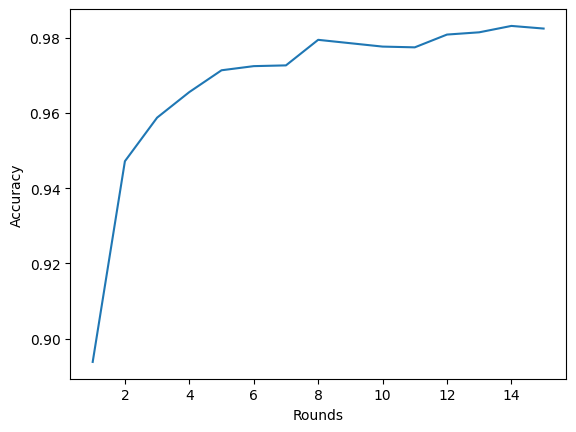

In [25]:
rounds_to_check = range(10, 20, 5)

history = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=rounds_to_check[-1]),
    strategy=strategy
)
plt.plot(*zip(*history.metrics_distributed['accuracy']))
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

**Atividade 2** 

Fizemos o aprendizado federado mediado por uma simulação, mas em um cenário real teríamos processos clientes, representando os treinadores, sendo executados em várias máquinas independentes, conectadas a um processo servidor (agregador) pela rede ou pela Internet, por exemplo. 

Como tarefa para casa deve-se  realizar o aprendizado federado de uma maneira mais próxima da realidade, usando processos diferentes para rodar os clientes e o servidor. 

Para isso será necessário criar 2 programas python, o *client.py* e o *server.py*: 


*   O *client.py* deve implementar uma classe que herda a classe  *NumpyClient*, fornecida pela biblioteca flower, instanciar um objeto dessa classe e se conectar ao servidor;
*   O *server.py* deve configurar um servidor de aprendizado federado usando um objeto *strategy* e um objeto *serverConfigserverConfig*. Em seguida deve-se iniciar o servidor para realizar o aprendizado com (no mínimo) 5 clientes.

O *server.py* e o *client.py* devem ser executados em terminais próprios. Isto é, deve se usar um minimo de  6 terminais na solução dessa tarefa: um para o  servidor e um para cada cliente (5 no mínimo). 

Ao final, plotar a acurácia para 2,5, 10, 20 e 40 *rounds* como a quantidade de clientes definida por você (mínimo  5).



Dicas:



*   Não é necessário utilizar várias máquinas para isso;

*    Nesta atividade podemos emular uma rede por meio da interface de rede *localhost* (IP: 127.0.0.1) onde os processos treinadores e servidores podem ser executados em terminais Linux separados conectando-se pelo endereço IP 127.0.0.1;
*   Como referência, usem a [documentação da biblioteca *flower*](https://flower.dev/docs/) na Seção QuickStart tutorials: tensorflow



**Atividade 3**\
**Obrigatória apenas para a pós-graduação** 

Usamos até agora uma rede neural convolucional para gerar o modelo treinado, tanto localmente como de maneira federada, mas o treinamento federado pode ser realizado (teoricamente) com qualquer classe de rede neural. 

Nesta atividade vocês deverão definir pelo menos 2 redes neurais não convolucionais para resolver o problema de classificação de dígitos com o *dataset mnist* e comparar os resultados do treinamento local e federado para essas redes.

Dicas:


*   O treinamento federado pode ser feito tanto por simulação, como este laboratório, ou com os programas *client.py* e *server.py* feitos na atividade anterior.


